In [2]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from online.envs.bidding_env import BiddingEnv
from definitions import ROOT_DIR
import json


In [3]:
# Load results and compute scores
path = ROOT_DIR / "data/results/eval_dense.json"
with open(path, "r") as f:
    data = json.load(f)
    
for key, value in data.items():
    score_list = []
    cost_over_budget_list = []
    target_cpa_over_cpa_list = []
    for exp in value:
        score_list.append(exp["score"]["mean"])
        cost_over_budget_list.append(exp["cost_over_budget"]["mean"])
        target_cpa_over_cpa_list.append(exp["target_cpa_over_cpa"]["mean"])
    print(key, "score, mean:", np.mean(score_list), "sem:", np.std(score_list) / np.sqrt(len(score_list)))
    print(key, "cost_over_budget, mean:", np.mean(cost_over_budget_list), "sem:", np.std(cost_over_budget_list) / np.sqrt(len(cost_over_budget_list)))
    print(key, "target_cpa_over_cpa, mean:", np.mean(target_cpa_over_cpa_list), "sem:", np.std(target_cpa_over_cpa_list) / np.sqrt(len(target_cpa_over_cpa_list)))
    

lp score, mean: 331.6622437600677 sem: 0.10878502356675034
lp cost_over_budget, mean: 0.5480623168455114 sem: 0.00011829300921454136
lp target_cpa_over_cpa, mean: 1.1020967750186401 sem: 0.00018807206332634554
ppo_score score, mean: 381.97355311135317 sem: 10.488324261691922
ppo_score cost_over_budget, mean: 0.8220034828703601 sem: 0.018733193313775306
ppo_score target_cpa_over_cpa, mean: 0.9078177481223705 sem: 0.019355013802386363
ppo_shaped score, mean: 384.71483041739765 sem: 13.122858104881388
ppo_shaped cost_over_budget, mean: 0.8717259477051423 sem: 0.03976688934857355
ppo_shaped target_cpa_over_cpa, mean: 0.907091685798878 sem: 0.024964675779883087
ppo_shaped_2_slopes score, mean: 291.5826132472817 sem: 22.40997651749159
ppo_shaped_2_slopes cost_over_budget, mean: 0.7811251601010305 sem: 0.021980192838642817
ppo_shaped_2_slopes target_cpa_over_cpa, mean: 0.8145846478784388 sem: 0.02082878467962609
oil score, mean: 466.3627880665622 sem: 0.433743930607874
oil cost_over_budget, m

In [3]:
pvalues_path = ROOT_DIR / "data" / "traffic" / "online_rl_data_dense" / "period-27_pvalues.parquet"
bids_path = ROOT_DIR / "data" / "traffic" / "online_rl_data_dense" / "period-27_bids.parquet"
budget_range = (2000, 5000)
target_cpa_range = (60, 130)
seed = 0
pv_range_list = list(np.linspace(0, 0.005, 101))
with open(ROOT_DIR / "data" / "obs_configs" / f"obs_60_keys.json", "r") as f:
    obs_keys = json.load(f)
env = BiddingEnv(pvalues_path, bids_path, budget_range, target_cpa_range, obs_keys=obs_keys, 
                 seed=seed, deterministic_conversion=True, single_io_bid=True, oracle_upgrade=True)

Loading pvalues from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/traffic/online_rl_data_dense/period-27_pvalues.parquet
Loading bids from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/traffic/online_rl_data_dense/period-27_bids.parquet


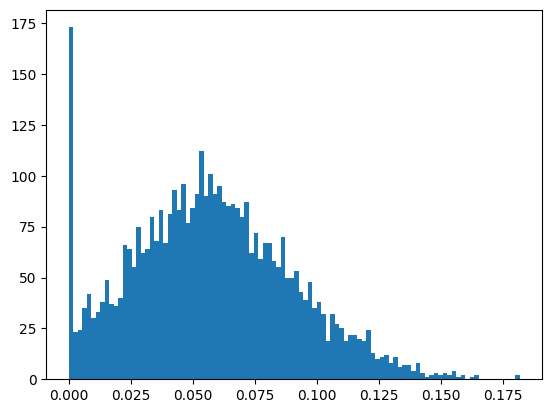

In [4]:
# Plot pv / cost over time for one advertiser
advertiser_id = 0
ts = 10
t_cpa = 8

bids_df = env.bids_df_list[0]
pvalues_df = env.pvalues_df
pv_vec = pvalues_df[(pvalues_df.advertiserNumber == advertiser_id) & (pvalues_df.timeStepIndex == ts)].pValue.item()
bids_mat = bids_df[(bids_df.timeStepIndex == ts)].bid.item()
cost_mat = bids_df[(bids_df.timeStepIndex == ts)].cost.item()
ad_mat = bids_df[(bids_df.timeStepIndex == ts)].advertiserNumber.item()
bids_mat[ad_mat == advertiser_id] = cost_mat[ad_mat == advertiser_id]
cost_vec = bids_mat[:, 0]

# Plot hist of the pvalues
plt.hist(pv_vec / cost_vec, bins=100)
plt.show()

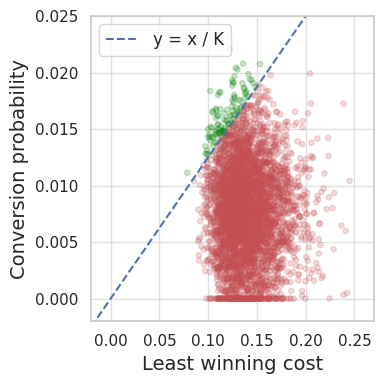

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

x_min = -0.02
y_min = -0.002
x_max = 0.27
y_max = 0.025

# Compute the decision boundary
xx = np.linspace(x_min, x_max, 100)
boundary_line = (1 / t_cpa) * xx

# Determine colors
colors = np.where(pv_vec > (1 / t_cpa) * cost_vec, 'green', 'r')

# Plot settings
sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 4))

# Scatter plot
scatter = plt.scatter(cost_vec, pv_vec, c=colors, s=15, alpha=0.2)

# Boundary line
plt.plot(xx, boundary_line, 'b--', label=f'y = x / K')

# Annotations
plt.xlabel('Least winning cost', fontsize=14)
plt.ylabel('Conversion probability', fontsize=14)
# plt.title('Scatterplot of Cost vs PV with Decision Boundary', fontsize=16)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, alpha=0.6)

# Reposition
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Show plot
plt.tight_layout()
plt.savefig(ROOT_DIR / "data" / "images" / "pv_vs_lwc.svg", format="svg")
plt.show()


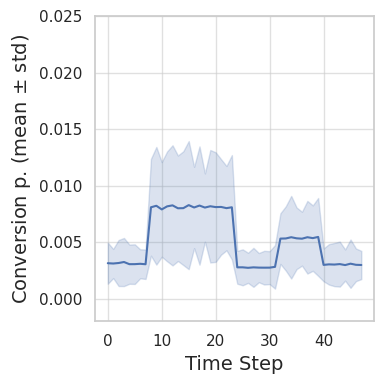

In [6]:
pv_time_series = pvalues_df[(pvalues_df.advertiserNumber == advertiser_id)].pValue.apply(np.mean)
pv_std_series = pvalues_df[(pvalues_df.advertiserNumber == advertiser_id)].pValue.apply(np.std)

# Plot settings
sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 4))

# Time series plot with shaded area
x = np.arange(len(pv_time_series))
plt.plot(x, pv_time_series, color='b')
plt.fill_between(x, pv_time_series - pv_std_series, pv_time_series + pv_std_series,
                 color='b', alpha=0.2)

# Annotations
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Conversion p. (mean $\pm$ std)', fontsize=14)
# plt.title('Time Series of Mean PV with Standard Deviation', fontsize=16)

# y range
plt.ylim(y_min, y_max)

# Legend and grid
plt.grid(True, alpha=0.6)

# Show plot
plt.tight_layout()
plt.savefig(ROOT_DIR / "data" / "images" / "pv_ts.svg", format="svg")
plt.show()

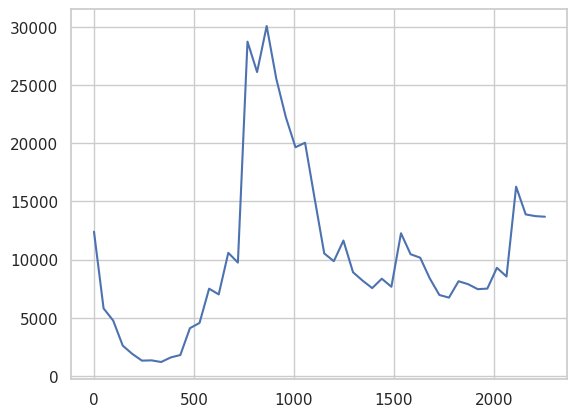

In [7]:
pv_time_series = pvalues_df[(pvalues_df.advertiserNumber == advertiser_id)].pValue.apply(lambda x: len(x))
plt.plot(pv_time_series)

In [10]:
df_path = ROOT_DIR / "data/traffic/raw_traffic_dense_parquet/period-27.parquet"
df = pd.read_parquet(df_path)
df.keys()

Index(['deliveryPeriodIndex', 'advertiserNumber', 'advertiserCategoryIndex',
       'budget', 'CPAConstraint', 'timeStepIndex', 'remainingBudget',
       'pvIndex', 'pValue', 'pValueSigma', 'bid', 'xi', 'adSlot', 'cost',
       'isExposed', 'conversionAction', 'leastWinningCost', 'isEnd'],
      dtype='object')

In [11]:
df.budget.min(), df.budget.max()

(450.0, 11850.0)

In [12]:
df.CPAConstraint.min(), df.CPAConstraint.max()

(6.0, 12.0)